# Clustering Enron Dataset

A simple machine learning approach to investigate the Enron email dataset by applying k-means algorithm to cluster the unlabeled emails where it classifies emails based on their message body.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

In [2]:
import os
emails = pd.read_csv('../input/emails.csv')
print(emails.shape)
emails.head()

(517401, 2)


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


Instead of loading in all +500k emails, as it's hard to fit such data within a PC's memory, the dataset will be chunked into segments with approximately 1[](http://)0k each.

In [3]:
out = None
for emails in pd.read_csv('../input/emails.csv', chunksize = 10000):
    if out is None:
        out = emails.copy()
    else:
        out.append(emails)
    out.head()

In [4]:
print(out.shape)

(10000, 2)


In [5]:
print (out.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
file       10000 non-null object
message    10000 non-null object
dtypes: object(2)
memory usage: 156.3+ KB
None


Now the out dataframe has 10k messages separated into 2 columns "file" and "message", before working with this dataset the body message should be parsed into key-value pairs where only the sender, receiver and email body data will be extracted from the body message.

In [6]:
# extract to, from and body from each email
def email_parsing(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to']
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email

In [7]:
# compile all extracted data into a single dictionary
def emails_parsing(messages):
    emails = [email_parsing(message) for message in messages]
    return {
        'body': result_append(emails, 'body'), 
        'to': result_append(emails, 'to'), 
        'from_': result_append(emails, 'from')
    }

In [8]:
# append all key results into single list
def result_append(emails, key):
    results = []
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results

In [9]:
# create a new dataframe for extracted data
extracted_data = pd.DataFrame(emails_parsing(out['message']))

In [10]:
# check any NaN values
extracted_data.isnull().any()

body     False
to       False
from_    False
dtype: bool

In [11]:
# drop empty values
# extracted_data.drop(extracted_data.query("body == '' | to == '' | from_ == ''").index, inplace = True)

To this point emails has no null records, yet its well-known that better encoding of categorical data means better performance as many machine learning algorithms cannot operate on label data directly, this means categorical data must be converted to a numerical form.

In [12]:
stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient'])
vect = TfidfVectorizer(analyzer = 'word', stop_words = stopwords, max_df = 0.5, min_df = 2)

In [13]:
X = vect.fit_transform(extracted_data.body)

Now the email bodies are converted into a document-term matrix to visualise this matrix we need to create 2d representation of the DTM (document-term matrix)

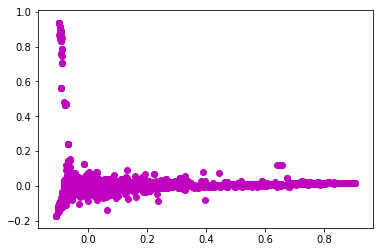

In [14]:
X_dense = X.todense()
coords = PCA(n_components=2).fit_transform(X_dense)
plt.scatter(coords[:, 0], coords[:, 1], c = 'm')

The next step is to find out the top keywords of each email, this can be done by creating a variable (features) that holds a list of all the words in the tf-idfs vocabulary in the same order as the columns in the matrix.

In [15]:
features = vect.get_feature_names()

In [16]:
def top_msg_features(X, features, row_id, top_words = 25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_features(row, features, top_words)

T[](http://)he following[](http://) function top_tfidf_features[](http://) takes a single row of the tf-idf matrix (corresponding to a particular message), and return the n highest scoring words (or more generally tokens or features).

In [17]:
def top_tfidf_features(row, features, top_words = 20):
	# argsort produces the indices that orders the row by tf-idf value
	# reverse them (into descending order) and select the top words
    top_ids = np.argsort(row)[::-1][:top_words]
    top_features = [(features[i], row[i]) for i in top_ids]
    df = pd.DataFrame(top_features, columns=['features', 'score'])
    return df

Hence, the output of a tf-idf is a sparse matrix which doesnt support matrix operations, so a single row need[](http://) first to be converted into dense format in order to apply top_tfidf_features function.

In [18]:
def top_msg_features(X, features, row_id, top_words = 25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_features(row, features, top_words)

The next step is to calculate the average tf-idf score of all words across all emails, in other words the average per column of a tf-idf matrix

In [19]:
def top_terms(X, features, grp_ids = None, min_tfidf = 0.1, top_words = 25):
    if grp_ids:
        msgs = X[grp_ids].toarray()
    else:
        msgs = X.toarray()
    msgs[msgs < min_tfidf] = 0
    # calculate the mean of each column across the selected rows (which results in a single row of tf-idf values)
    tfidf_means = np.mean(msgs, axis = 0)
    # then pass on to the previous func for picking out the top n words
    return top_tfidf_features(tfidf_means, features, top_words)

"grp_ids" takes a list of row indices which pick out some particular messages that you want to inspect providing "None" indicates, that you are interested in all messages (emails).

# K-Means Clustering

K-means clustering is one of the simplest and popular clustering algorithms that stores k centroids that it uses to define clusters.

In [20]:
# create classifier with 3 clusters and 100 iterations
clf = KMeans(n_clusters = 3, max_iter = 100, init = 'k-means++', n_init = 1)
labels = clf.fit_predict(X)

To visualise it, we need to make 2d coordinates from the sparse matrix.

In [21]:
X_dense = X.todense()
pca = PCA(n_components = 2).fit(X_dense)
coords = pca.transform(X_dense)

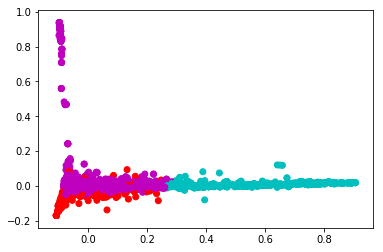

In [22]:
label_colours = ['c', 'm', 'r']
colours = [label_colours[i] for i in labels]
plt.scatter(coords[:, 0], coords[:, 1], c = colours)

Now as it's known which emails the model assigned to each cluster, it's possible to extract the top words per cluster.

In [23]:
def top_words_per_cluster(X, y, features, min_tfidf = 0.1, top_words = 25):
    dfs = []

    labels = np.unique(y)
    for label in labels:
        ids = np.where(y == label) 
        features_df = top_terms(X, features, ids, min_tfidf = min_tfidf, top_words = top_words)
        features_df.label = label
        dfs.append(features_df)
    return dfs

In [24]:
def plot_top_words(dfs):
    fig = plt.figure(figsize = (11, 8), facecolor = "w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad = 16, fontsize = 13)
        ax.set_title("cluster = " + str(df.label), fontsize = 15)
        ax.ticklabel_format(axis = 'x', style = 'sci', scilimits = (-2, 2))
        ax.barh(x, df.score, align = 'center', color = '#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1] + 1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom = 0.09, right = 0.97, left = 0.15, top = 0.95, wspace = 0.52)
    plt.show()

In [25]:
tops = top_words_per_cluster(X, labels, features, 0.1, 25)

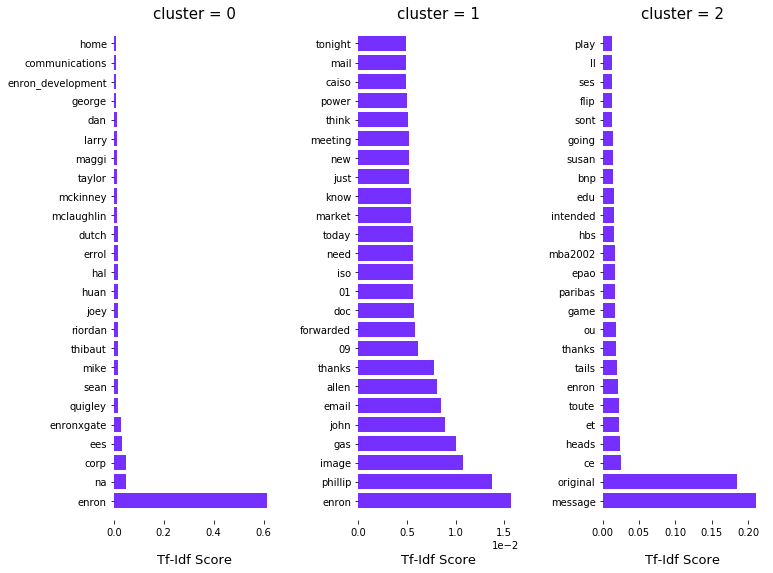

In [26]:
plot_top_words(tops)